## **Section 1: Setup and Installations**

In [3]:
!pip install spacy imbalanced-learn xgboost ipywidgets
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 91.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import pandas as pd
import joblib
import re
import spacy
from sklearn.base import clone
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from IPython.display import display
import ipywidgets as widgets
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)

## **Section 2: Configuration and Initialization**


In [5]:
# Initialize spaCy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Configure display and warning settings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option('display.max_colwidth', 100)
plt.style.use('ggplot')

# Path configurations for datasets
DATASETS = {
    "amazon": "/content/drive/MyDrive/NLPDataset/amazon.csv",
    "imdb": "/content/drive/MyDrive/NLPDataset/imdb.csv"
}

# Mount Google Drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Section 3: Data Loading Function**

In [6]:
from sklearn.preprocessing import LabelEncoder

def load_data(path):
    """
    Load dataset and prepare for classification

    Args:
        path (str): Path to the dataset

    Returns:
        tuple: Processed DataFrame, class names, dataset type, text column, target column, label encoder
    """
    # Read the CSV file
    df = pd.read_csv(path)
    path_str = str(path).lower()

    # Determine text and target columns based on dataset
    if 'amazon' in path_str:
        text_col = 'review'
        target_col = 'category'
        dataset_type = 'amazon'
    else:
        text_col = next(col for col in ['text', 'review', 'comment', 'message'] if col in df.columns)
        target_col = next(col for col in ['sentiment', 'label'] if col in df.columns)
        dataset_type = 'imdb'

    # Encode labels
    le = LabelEncoder()
    df[target_col] = df[target_col].astype(str).str.strip().str.lower()
    df['encoded_labels'] = le.fit_transform(df[target_col])

    return df, le.classes_, dataset_type, text_col, target_col, le

# Example usage
df_amazon, class_names_amazon, dataset_type_amazon, text_col_amazon, target_col_amazon, le_amazon = load_data(DATASETS['amazon'])
print("\n=== Amazon Dataset Loaded Successfully ===")
print("Dataset Type:", dataset_type_amazon)
print("Class Names:", class_names_amazon)
print("Text Column:", text_col_amazon)
print("Target Column:", target_col_amazon)

# Load IMDb dataset
df_imdb, class_names_imdb, dataset_type_imdb, text_col_imdb, target_col_imdb, le_imdb = load_data(DATASETS['imdb'])
print("\n=== IMDb Dataset Loaded Successfully ===")
print("Dataset Type:", dataset_type_imdb)
print("Class Names:", class_names_imdb)
print("Text Column:", text_col_imdb)
print("Target Column:", target_col_imdb)


=== Amazon Dataset Loaded Successfully ===
Dataset Type: amazon
Class Names: ['packaging' 'pricing' 'quality' 'service' 'shipping']
Text Column: review
Target Column: category

=== IMDb Dataset Loaded Successfully ===
Dataset Type: imdb
Class Names: ['negative' 'positive']
Text Column: review
Target Column: sentiment


## **Section 4: Exploratory Data Analysis (EDA)**

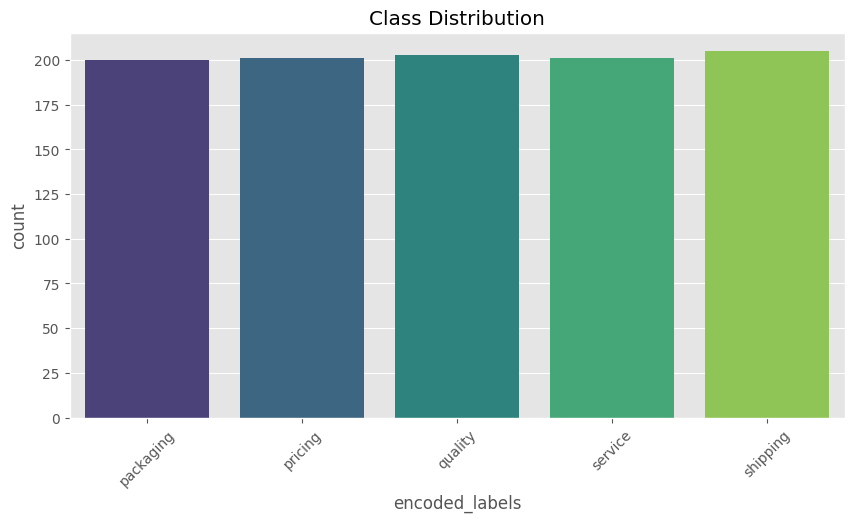

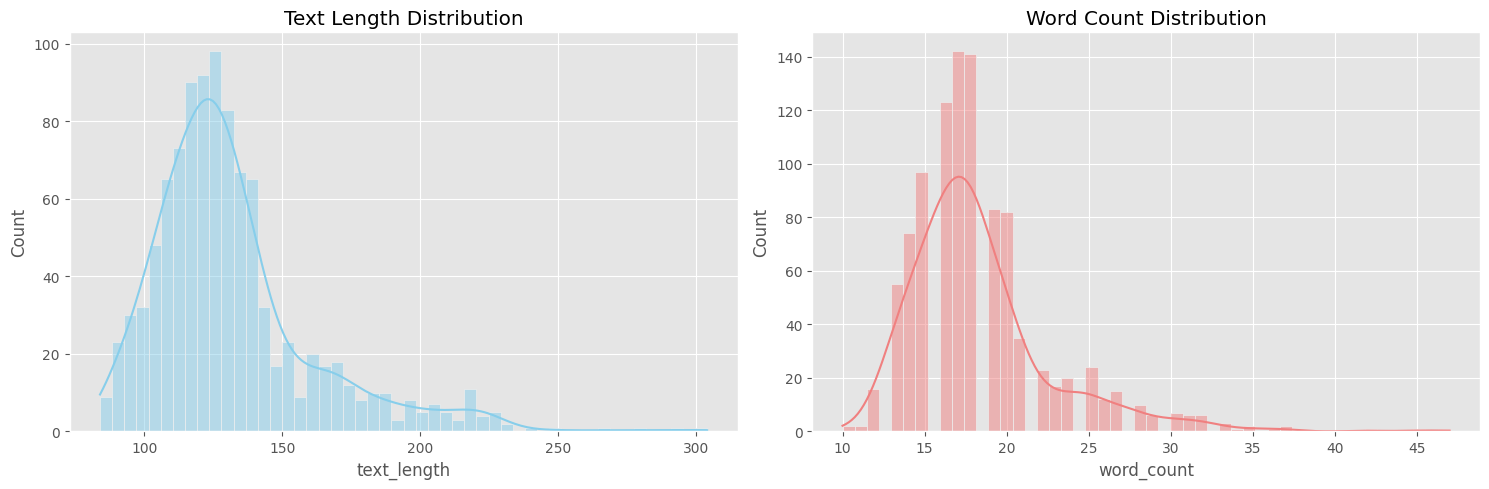

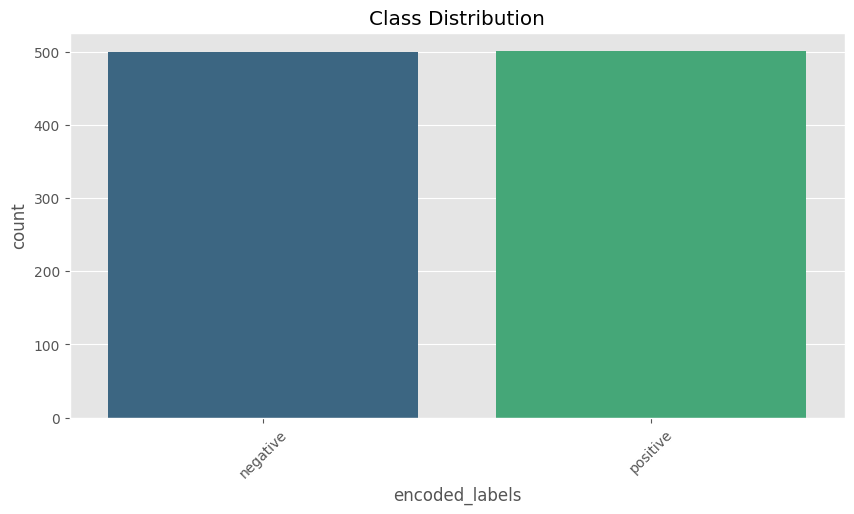

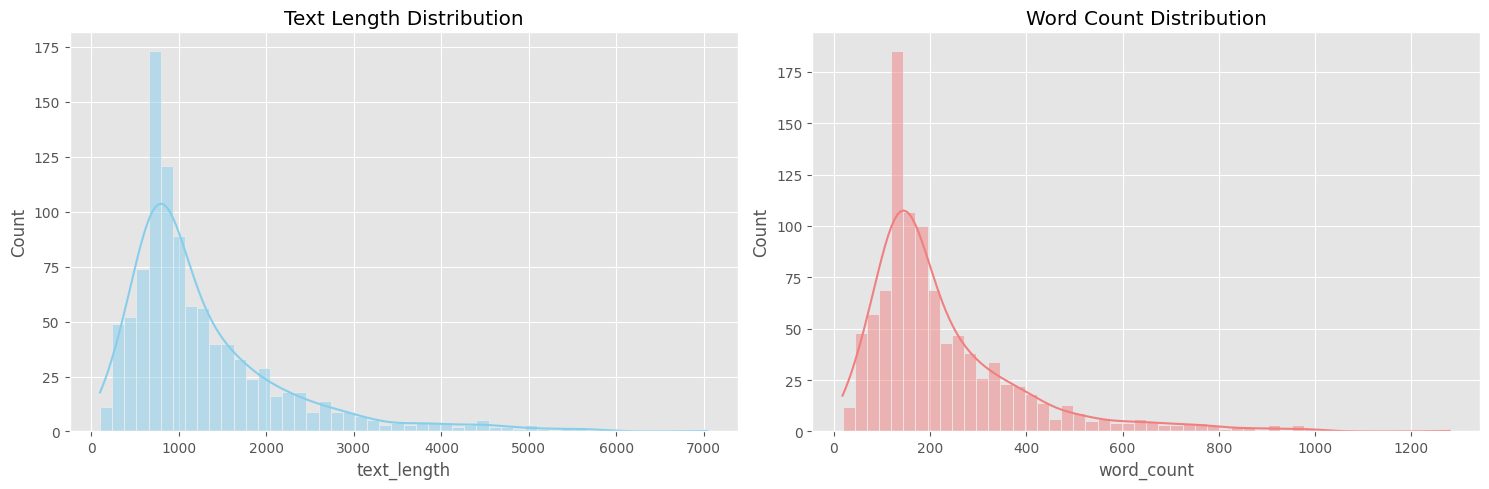

In [7]:
def show_eda(df, class_names, text_col):
    # Plot class distribution
    plt.figure(figsize=(10, 5))
    sns.countplot(x=df['encoded_labels'], palette='viridis')
    plt.title("Class Distribution")
    plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
    plt.show()

    # Add text length and word count features
    df['text_length'] = df[text_col].apply(len)
    df['word_count'] = df[text_col].apply(lambda x: len(x.split()))

    # Plot text length and word count distributions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(df['text_length'], bins=50, ax=ax1, kde=True, color='skyblue')
    ax1.set_title("Text Length Distribution")

    sns.histplot(df['word_count'], bins=50, ax=ax2, kde=True, color='lightcoral')
    ax2.set_title("Word Count Distribution")

    plt.tight_layout()
    plt.show()

# Show EDA for Amazon dataset
show_eda(df_amazon, class_names_amazon, text_col_amazon)

# Show EDA for IMDb dataset
show_eda(df_imdb, class_names_imdb, text_col_imdb)



## **Section 5: Text Preprocessing**

In [8]:
def preprocess_text(text, dataset_type):
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Use spaCy for advanced text processing
    doc = nlp(text.lower())

    # Lemmatization and stopword removal
    lemmas = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and token.is_alpha and len(token.lemma_) > 2
    ]

    # Additional feature extraction for amazon dataset
    if dataset_type == 'amazon':
        lemmas += [
            token.text.lower()
            for token in doc
            if token.pos_ in ['ADJ', 'ADV'] and len(token.text) > 2
        ]

    return ' '.join(lemmas)

# Example usage
sample_text = "This is an amazing product with great quality, but movie was good! too!"
cleaned_text = preprocess_text(sample_text, 'amazon')
print("Original Text:", sample_text)
print("Cleaned Text:", cleaned_text)

Original Text: This is an amazing product with great quality, but movie was good! too!
Cleaned Text: amazing product great quality movie good amazing great good too


## **Section 6: Deep Learning Model Implementation and Evaluation**

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GRU, Dropout
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.preprocessing import LabelEncoder

# Preprocessing for Deep Learning
def prepare_dl_data(df, text_col, target_col, max_len=200, max_words=10000):
    # Return both processed sequences and raw text
    # Traditional preprocessing
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(df[text_col])
    sequences = tokenizer.texts_to_sequences(df[text_col])
    X_processed = pad_sequences(sequences, maxlen=max_len)

    # Raw text for BERT
    X_text = df[text_col].values

    # Label encoding
    le = LabelEncoder()
    y = le.fit_transform(df[target_col])

    return (X_processed, X_text, y), tokenizer, le

## **Section 7: Train DL Models**

In [82]:
# Model 1: Bidirectional LSTM
import time # Import the time module
start_time = time.time() # Initialize start_time before training

def train_lstm(X_train, y_train, X_val, y_val, num_classes, max_words=10000, embedding_dim=128):
    start_time = time.time() # Initialize start_time before training
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=X_train.shape[1]),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(32)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        # Use 'softmax' activation and 'sparse_categorical_crossentropy' for all cases
        Dense(num_classes, activation='softmax') # Changed to softmax
    ])

    model.compile(loss='sparse_categorical_crossentropy', # Changed to sparse_categorical_crossentropy
                 optimizer='adam',
                 metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                       epochs=10,
                       batch_size=64,
                       validation_data=(X_val, y_val),
                       verbose=1)
    history.history['time'] = [time.time() - start_time] * len(history.history['loss'])  # Store training time for each epoch

    return model, history

# Model 2: GRU with Attention
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

def train_gru_with_attention(X_train, y_train, X_val, y_val, num_classes):
    model = Sequential([
        Embedding(10000, 128),
        GRU(128, return_sequences=True),
        AttentionLayer(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')  # Changed for multi-class support
    ])

    model.compile(loss='sparse_categorical_crossentropy',  # Updated loss function
                 optimizer='adam',
                 metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                       epochs=10,
                       batch_size=64,
                       validation_data=(X_val, y_val),
                       verbose=1)
    return model, history

# Model 3: BERT Fine-tuning
def train_bert(X_train_text, y_train, X_val_text, y_val, num_classes):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Convert to list of strings
    train_texts = X_train_text.tolist()
    val_texts = X_val_text.tolist()

    # Tokenization
    train_encodings = tokenizer(
        train_texts,
        truncation=True,
        padding=True,
        max_length=200
    )

    val_encodings = tokenizer(
        val_texts,
        truncation=True,
        padding=True,
        max_length=200
    )

    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        y_train
    ))

    val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(val_encodings),
        y_val
    ))

    # Model initialization
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

    # Compile model - FIXED: Use optimizer name as string instead of instantiated object
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

    # Training
    history = model.fit(
        train_dataset.shuffle(1000).batch(16),
        epochs=3,
        validation_data=val_dataset.batch(16)
    )

    return model, history, tokenizer

# Model 4: 1D CNN
def train_cnn(X_train, y_train, X_val, y_val, num_classes, max_words=10000, embedding_dim=128):
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=X_train.shape[1]),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                       epochs=10,
                       batch_size=64,
                       validation_data=(X_val, y_val),
                       verbose=1)
    return model, history

## **Section 8: Model Training & Evaluations**

In [97]:
import pandas as pd
from IPython.display import display
import numpy as np
def evaluate_model(model, X_test, y_test, history, dataset_type, model_name, class_names, tokenizer=None):
    # Training history matrix
    history_df = pd.DataFrame(history.history)
    if 'time' in history_df.columns:
        history_df = history_df.drop(columns=['time'])
    history_df['epoch'] = np.arange(1, len(history_df)+1)

    print(f"\n{model_name} Training Matrix:")
    display(history_df.style.format({
        'accuracy': '{:.4f}', 'val_accuracy': '{:.4f}',
        'loss': '{:.4f}', 'val_loss': '{:.4f}'
    }))

    # Handle BERT evaluation differently
    if 'bert' in model_name.lower():
        test_texts = X_test.tolist() if isinstance(X_test, np.ndarray) else X_test
        test_encodings = tokenizer(
            test_texts,
            truncation=True,
            padding=True,
            max_length=200,
            return_tensors='tf'
        )
        test_dataset = tf.data.Dataset.from_tensor_slices((
            dict(test_encodings),
            y_test
        )).batch(16)

        # Get evaluation results properly
        eval_results = model.evaluate(test_dataset, verbose=0)
        if isinstance(eval_results, list):
            loss = eval_results[0]
            accuracy = eval_results[1]
        else:
            loss = eval_results
            accuracy = 0.0  # Fallback value
        y_pred = model.predict(test_dataset).logits
    else:
        # Traditional model evaluation
        eval_results = model.evaluate(X_test, y_test, verbose=0)
        if isinstance(eval_results, list):
            loss = eval_results[0]
            accuracy = eval_results[1]
        else:
            loss = eval_results
            accuracy = 0.0  # Fallback value
        y_pred = model.predict(X_test)

    print(f"\n{model_name} Final Evaluation:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Loss: {loss:.4f}")

    # Rest of your existing code for metrics calculation...
    y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes,
                           target_names=class_names if dataset_type == 'amazon' else ['negative', 'positive']))

    # Return metrics (make sure to include accuracy)
    return {
        'model': model_name,
        'test_accuracy': accuracy,
        'test_loss': loss,
        'training_time': sum(history.history.get('time', [0])),
        'precision': precision_score(y_test, y_pred_classes, average='weighted'),
        'recall': recall_score(y_test, y_pred_classes, average='weighted'),
        'f1': f1_score(y_test, y_pred_classes, average='weighted')
    }

def predict_sample(text, model, tokenizer, le, model_type, max_len=200):
    if model_type == 'bert':
        inputs = tokenizer(
            text,
            return_tensors='tf',
            truncation=True,
            padding=True,
            max_length=max_len
        )
        outputs = model(inputs)
        probs = tf.nn.softmax(outputs.logits, axis=-1).numpy()[0]
        return {cls: prob for cls, prob in zip(le.classes_, probs)}
    else:
        sequence = tokenizer.texts_to_sequences([text])
        padded = pad_sequences(sequence, maxlen=max_len)
        pred = model.predict(padded)
        probs = tf.nn.softmax(pred).numpy()[0]
        return {cls: prob for cls, prob in zip(le.classes_, probs)}

## **Section 9: Real-world Validation**


Training on AMAZON Dataset
Classes: ['packaging' 'pricing' 'quality' 'service' 'shipping']

Training BiLSTM Model:
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.2258 - loss: 1.6088 - val_accuracy: 0.2426 - val_loss: 1.5916
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3721 - loss: 1.5571 - val_accuracy: 0.4208 - val_loss: 1.4018
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4628 - loss: 1.2697 - val_accuracy: 0.5198 - val_loss: 1.0082
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5660 - loss: 0.9151 - val_accuracy: 0.7574 - val_loss: 0.7372
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8316 - loss: 0.5651 - val_accuracy: 0.8663 - val_loss: 0.4424
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9548 - loss: 0.2593 - val_accuracy: 0.8713 - val_loss: 0.3396
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9932 - loss: 0.1068 - val_accuracy: 0.9059 - val_loss: 

,accuracy,loss,val_accuracy,val_loss,epoch
0,0.2401,1.6066,0.2426,1.5916,1
1,0.3899,1.5266,0.4208,1.4018,2
2,0.5025,1.1692,0.5198,1.0082,3
3,0.6312,0.8381,0.7574,0.7372,4
4,0.8639,0.4941,0.8663,0.4424,5
5,0.9641,0.2310,0.8713,0.3396,6
6,0.9926,0.0941,0.9059,0.2812,7
7,0.9950,0.0552,0.8713,0.4609,8
8,0.9963,0.0432,0.9307,0.2366,9
9,0.9950,0.0534,0.9158,0.3360,10


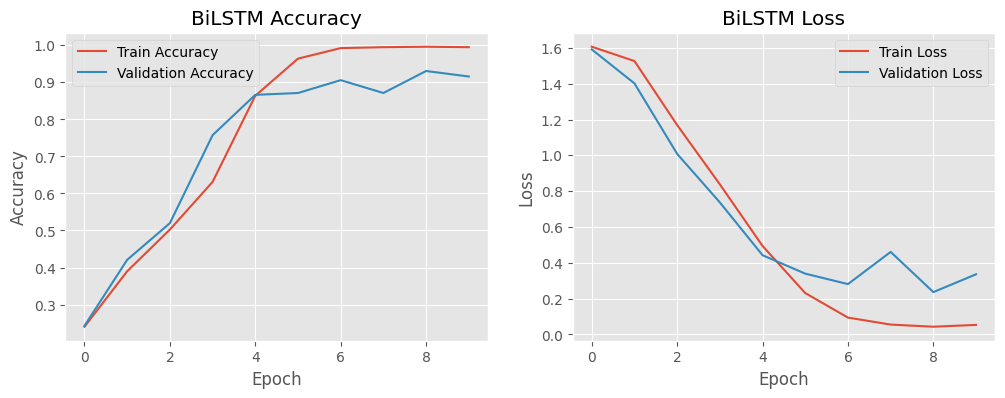

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step

BiLSTM Final Evaluation:
Test Accuracy: 0.9158
Test Loss: 0.3360

Classification Report:
              precision    recall  f1-score   support

   packaging       1.00      0.85      0.92        40
     pricing       0.97      0.82      0.89        40
     quality       0.83      0.98      0.90        41
     service       0.95      0.97      0.96        40
    shipping       0.87      0.95      0.91        41

    accuracy                           0.92       202
   macro avg       0.92      0.92      0.92       202
weighted avg       0.92      0.92      0.92       202



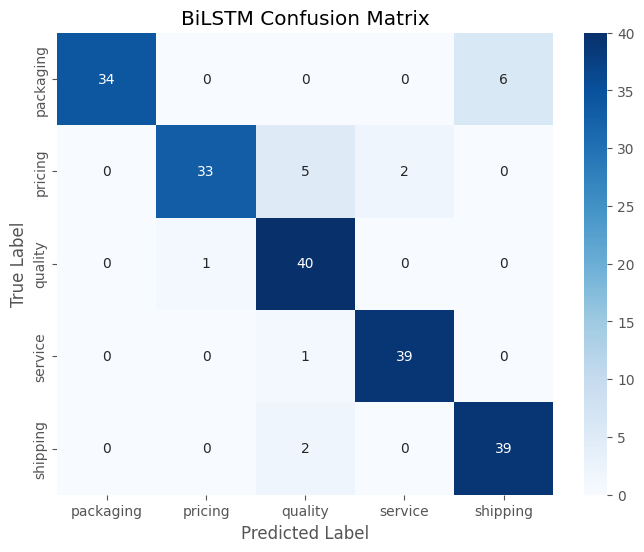


Training GRU with Attention Model:
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.2022 - loss: 1.6151 - val_accuracy: 0.2030 - val_loss: 1.6099
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1979 - loss: 1.6099 - val_accuracy: 0.1980 - val_loss: 1.6091
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2272 - loss: 1.6091 - val_accuracy: 0.2030 - val_loss: 1.6073
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2123 - loss: 1.6071 - val_accuracy: 0.2030 - val_loss: 1.6041
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1997 - loss: 1.6033 - val_accuracy: 0.2475 - val_loss: 1.5964
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3426 - loss: 1.5886 - val_accuracy: 0.2624 - val_loss: 1.5606
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4672 - loss: 1.4961 - val_accuracy: 0.5396 - val_loss: 1.1696
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5868 - los

,accuracy,loss,val_accuracy,val_loss,epoch
0,0.1980,1.6160,0.2030,1.6099,1
1,0.1906,1.6114,0.1980,1.6091,2
2,0.2215,1.6094,0.2030,1.6073,3
3,0.2290,1.6078,0.2030,1.6041,4
4,0.2290,1.6015,0.2475,1.5964,5
5,0.2896,1.5849,0.2624,1.5606,6
6,0.5272,1.4171,0.5396,1.1696,7
7,0.6126,0.9323,0.6238,0.8281,8
8,0.8317,0.5957,0.9010,0.4954,9
9,0.9604,0.2727,0.9158,0.3256,10


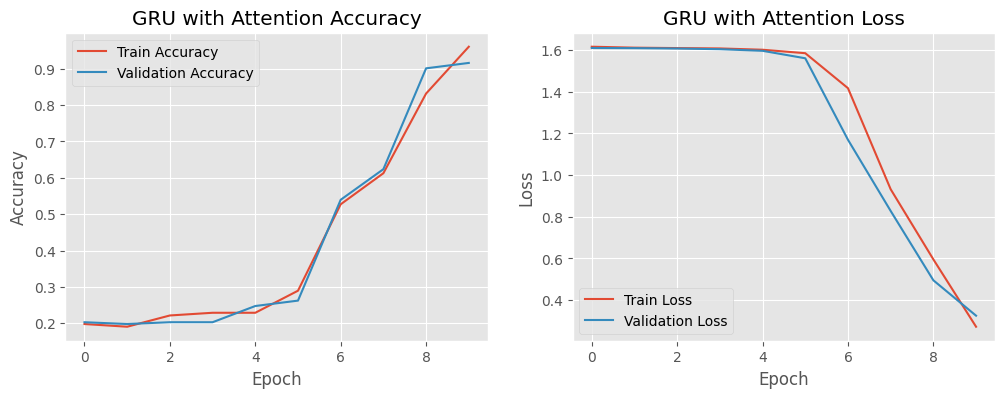

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

GRU with Attention Final Evaluation:
Test Accuracy: 0.9158
Test Loss: 0.3256

Classification Report:
              precision    recall  f1-score   support

   packaging       0.86      0.95      0.90        40
     pricing       1.00      0.85      0.92        40
     quality       0.82      1.00      0.90        41
     service       0.97      0.97      0.97        40
    shipping       0.97      0.80      0.88        41

    accuracy                           0.92       202
   macro avg       0.93      0.92      0.92       202
weighted avg       0.93      0.92      0.92       202



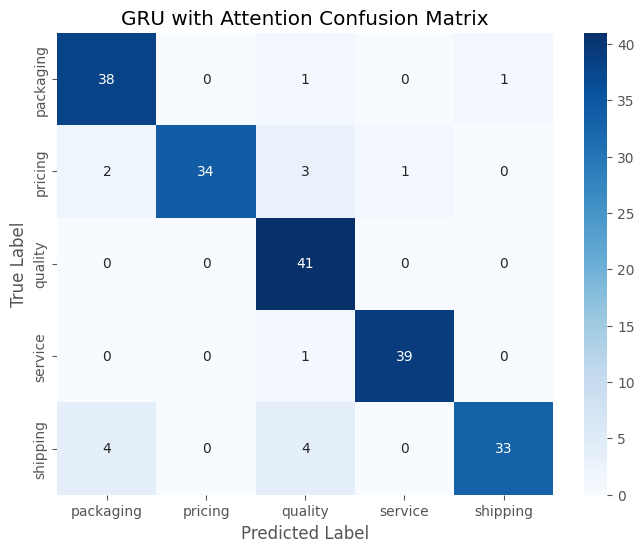


Training CNN Model:
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.2153 - loss: 1.5998 - val_accuracy: 0.6485 - val_loss: 1.5468
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6109 - loss: 1.4897 - val_accuracy: 0.7723 - val_loss: 1.4318
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7756 - loss: 1.3099 - val_accuracy: 0.8168 - val_loss: 1.2021
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8665 - loss: 1.0088 - val_accuracy: 0.8960 - val_loss: 0.8538
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9291 - loss: 0.6234 - val_accuracy: 0.9208 - val_loss: 0.5432
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9489 - loss: 0.3494 - val_accuracy: 0.9604 - val_loss: 0.3206
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9881 - loss: 0.1529 - val_accuracy: 0.9703 - val_loss: 0.2102
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9953 - loss: 0.0905 - va

,accuracy,loss,val_accuracy,val_loss,epoch
0,0.2413,1.5910,0.6485,1.5468,1
1,0.6114,1.4720,0.7723,1.4318,2
2,0.7995,1.2641,0.8168,1.2021,3
3,0.8700,0.9377,0.8960,0.8538,4
4,0.9394,0.5560,0.9208,0.5432,5
5,0.9629,0.2975,0.9604,0.3206,6
6,0.9864,0.1389,0.9703,0.2102,7
7,0.9950,0.0760,0.9703,0.1563,8
8,0.9950,0.0526,0.9752,0.1283,9
9,1.0000,0.0317,0.9703,0.1177,10


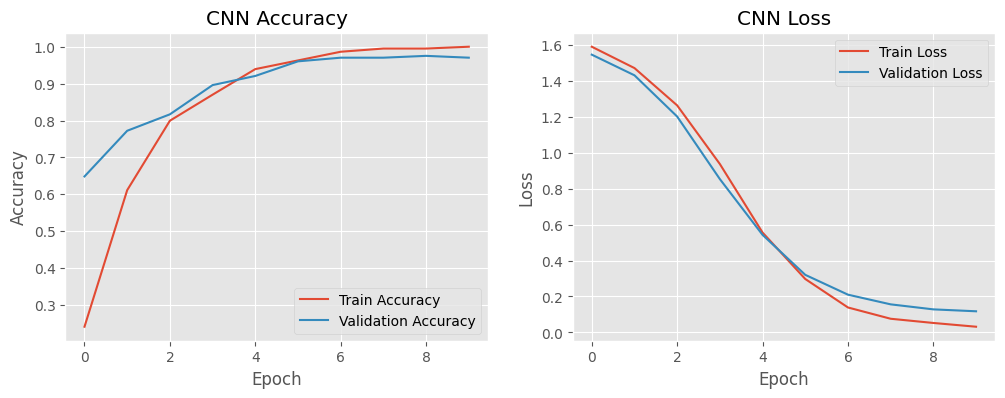

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

CNN Final Evaluation:
Test Accuracy: 0.9703
Test Loss: 0.1177

Classification Report:
              precision    recall  f1-score   support

   packaging       0.89      0.97      0.93        40
     pricing       1.00      1.00      1.00        40
     quality       1.00      0.95      0.97        41
     service       1.00      1.00      1.00        40
    shipping       0.97      0.93      0.95        41

    accuracy                           0.97       202
   macro avg       0.97      0.97      0.97       202
weighted avg       0.97      0.97      0.97       202



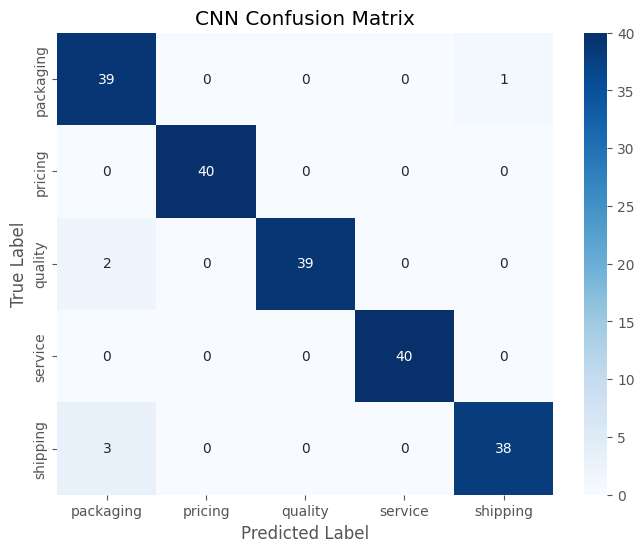


Training BERT Model:


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
51/51 [==============================] - 59s 317ms/step - loss: 1.7375 - accuracy: 0.1980 - val_loss: 1.6902 - val_accuracy: 0.1980
Epoch 2/3
51/51 [==============================] - 13s 259ms/step - loss: 1.7268 - accuracy: 0.1856 - val_loss: 1.6580 - val_accuracy: 0.1980
Epoch 3/3
51/51 [==============================] - 13s 250ms/step - loss: 1.6910 - accuracy: 0.2030 - val_loss: 1.6391 - val_accuracy: 0.2030

BERT Training Matrix:


,loss,accuracy,val_loss,val_accuracy,epoch
0,1.7375,0.1980,1.6902,0.1980,1
1,1.7268,0.1856,1.6580,0.1980,2
2,1.6910,0.2030,1.6391,0.2030,3


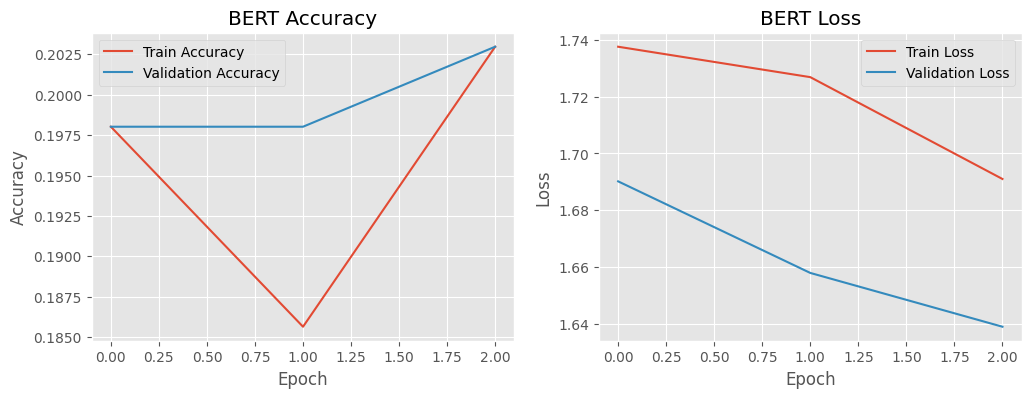

13/13 [==============================] - 5s 72ms/step

BERT Final Evaluation:
Test Accuracy: 0.2030
Test Loss: 1.6391

Classification Report:
              precision    recall  f1-score   support

   packaging       0.00      0.00      0.00        40
     pricing       0.00      0.00      0.00        40
     quality       0.20      1.00      0.34        41
     service       0.00      0.00      0.00        40
    shipping       0.00      0.00      0.00        41

    accuracy                           0.20       202
   macro avg       0.04      0.20      0.07       202
weighted avg       0.04      0.20      0.07       202



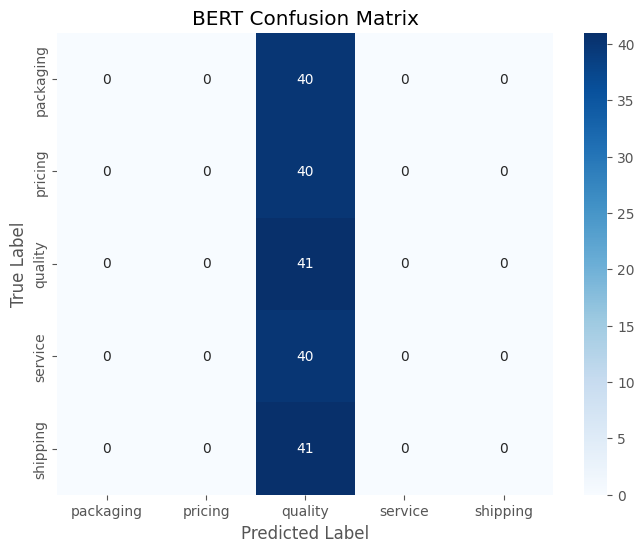


Real-world Predictions:

Text: The product packaging was excellent but the item arrived damaged
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
BiLSTM Prediction:
  packaging: 16.84%
  pricing: 16.48%
  quality: 35.22%
  service: 15.57%
  shipping: 15.89%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GRU with Attention Prediction:
  packaging: 19.85%
  pricing: 15.79%
  quality: 32.25%
  service: 15.91%
  shipping: 16.21%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
CNN Prediction:
  packaging: 33.49%
  pricing: 17.68%
  quality: 15.97%
  service: 15.68%
  shipping: 17.19%
BERT Prediction:
  packaging: 21.19%
  pricing: 11.55%
  quality: 24.76%
  service: 20.55%
  shipping: 21.95%

Text: Highly recommend this service, worth every penny!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
BiLSTM Prediction:
  packaging: 15.11%
  pricing: 15.26%
  quality: 38.74%
  service: 15.64%
  shipping: 15.25%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GRU with Attention Prediction:
  packaging: 15.88%
  pricing: 15.18%
  quality: 38.19%
 

,accuracy,loss,val_accuracy,val_loss,epoch
0,0.4888,0.6934,0.5150,0.6910,1
1,0.6250,0.6743,0.6150,0.6676,2
2,0.8037,0.4958,0.7050,0.5769,3
3,0.9438,0.1888,0.7150,0.9493,4
4,0.9962,0.0252,0.7450,0.9426,5
5,0.9950,0.0198,0.7150,1.1346,6
6,0.9950,0.0144,0.7000,1.3127,7
7,0.9987,0.0061,0.6700,1.6496,8
8,0.9962,0.0137,0.6750,1.4950,9
9,1.0000,0.0020,0.6700,1.7926,10


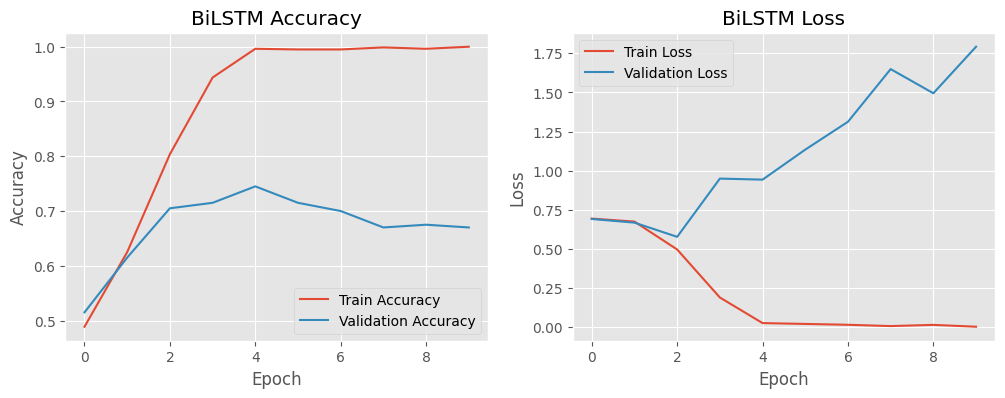

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step

BiLSTM Final Evaluation:
Test Accuracy: 0.6700
Test Loss: 1.7926

Classification Report:
              precision    recall  f1-score   support

    negative       0.69      0.62      0.65       100
    positive       0.65      0.72      0.69       100

    accuracy                           0.67       200
   macro avg       0.67      0.67      0.67       200
weighted avg       0.67      0.67      0.67       200



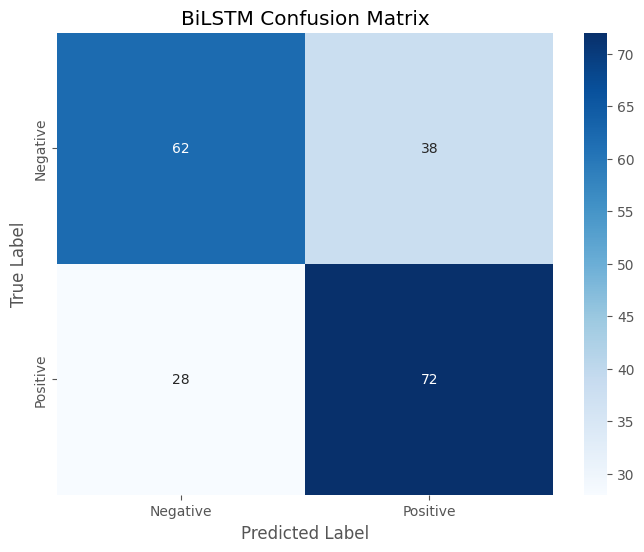


Training GRU with Attention Model:
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.5151 - loss: 0.6943 - val_accuracy: 0.5550 - val_loss: 0.6912
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5627 - loss: 0.6882 - val_accuracy: 0.6350 - val_loss: 0.6801
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7167 - loss: 0.6512 - val_accuracy: 0.6900 - val_loss: 0.5910
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8273 - loss: 0.4662 - val_accuracy: 0.6650 - val_loss: 0.6174
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9036 - loss: 0.3887 - val_accuracy: 0.7100 - val_loss: 0.5335
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9425 - loss: 0.2789 - val_accuracy: 0.7550 - val_loss: 0.5130
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9814 - loss: 0.0892 - val_accuracy: 0.8000 - val_loss: 0.7686
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9909 - los

,accuracy,loss,val_accuracy,val_loss,epoch
0,0.5138,0.6947,0.5550,0.6912,1
1,0.5688,0.6862,0.6350,0.6801,2
2,0.7138,0.6309,0.6900,0.5910,3
3,0.7987,0.5147,0.6650,0.6174,4
4,0.9162,0.3961,0.7100,0.5335,5
5,0.9513,0.2353,0.7550,0.5130,6
6,0.9850,0.0685,0.8000,0.7686,7
7,0.9937,0.0411,0.7900,1.4712,8
8,0.9975,0.0179,0.7500,0.5862,9
9,1.0000,0.0098,0.7950,0.5254,10


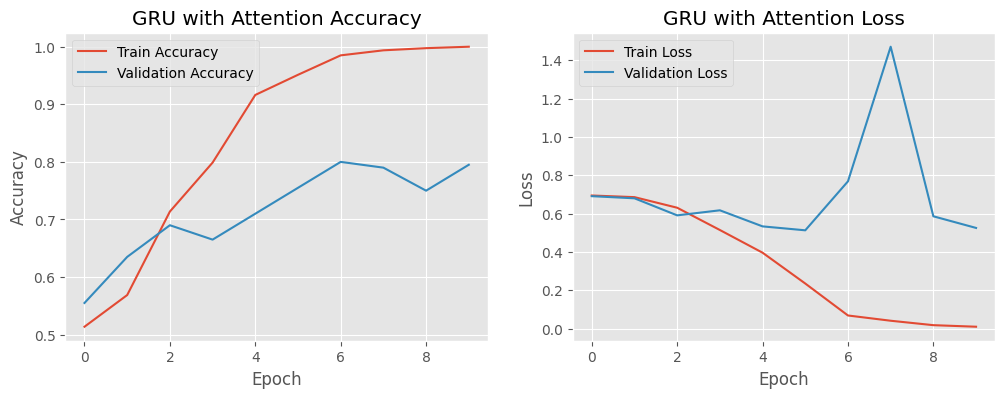

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

GRU with Attention Final Evaluation:
Test Accuracy: 0.7950
Test Loss: 0.5254

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.76      0.79       100
    positive       0.78      0.83      0.80       100

    accuracy                           0.80       200
   macro avg       0.80      0.79      0.79       200
weighted avg       0.80      0.80      0.79       200



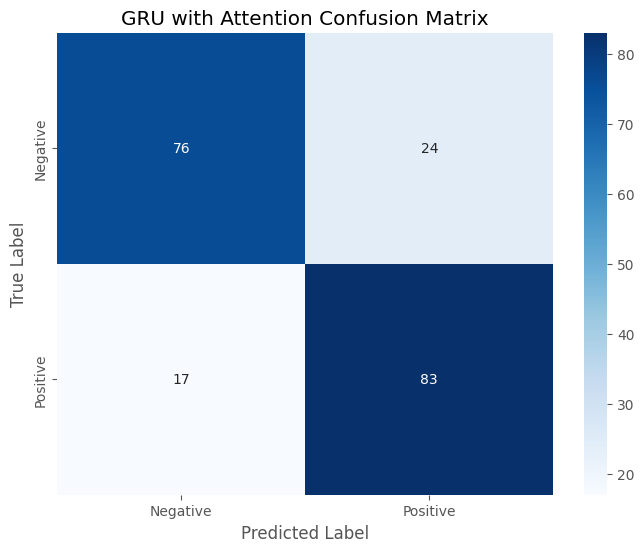


Training CNN Model:
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.5210 - loss: 0.6945 - val_accuracy: 0.6200 - val_loss: 0.6903
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6687 - loss: 0.6666 - val_accuracy: 0.6350 - val_loss: 0.6844
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8250 - loss: 0.6214 - val_accuracy: 0.6500 - val_loss: 0.6725
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8997 - loss: 0.5511 - val_accuracy: 0.6850 - val_loss: 0.6488
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9654 - loss: 0.4341 - val_accuracy: 0.7300 - val_loss: 0.6042
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9957 - loss: 0.2842 - val_accuracy: 0.7350 - val_loss: 0.5532
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9997 - loss: 0.1545 - val_accuracy: 0.7600 - val_loss: 0.5069
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0755 - va

,accuracy,loss,val_accuracy,val_loss,epoch
0,0.5113,0.6947,0.6200,0.6903,1
1,0.6837,0.6609,0.6350,0.6844,2
2,0.8388,0.6144,0.6500,0.6725,3
3,0.9150,0.5390,0.6850,0.6488,4
4,0.9613,0.4180,0.7300,0.6042,5
5,0.9962,0.2656,0.7350,0.5532,6
6,0.9987,0.1392,0.7600,0.5069,7
7,1.0000,0.0674,0.7800,0.4764,8
8,1.0000,0.0340,0.7650,0.4704,9
9,1.0000,0.0209,0.7750,0.4604,10


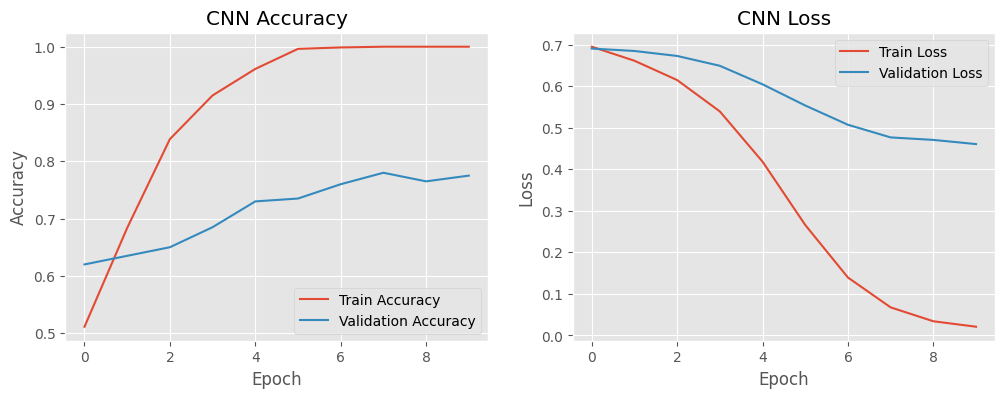

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

CNN Final Evaluation:
Test Accuracy: 0.7750
Test Loss: 0.4604

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.71      0.76       100
    positive       0.74      0.84      0.79       100

    accuracy                           0.78       200
   macro avg       0.78      0.77      0.77       200
weighted avg       0.78      0.78      0.77       200



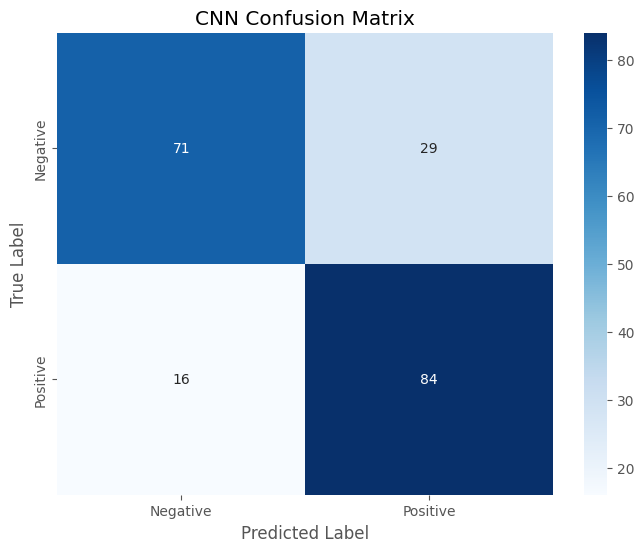


Training BERT Model:


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
50/50 [==============================] - 80s 779ms/step - loss: 0.8047 - accuracy: 0.4888 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/3
50/50 [==============================] - 36s 718ms/step - loss: 0.7188 - accuracy: 0.5138 - val_loss: 0.7041 - val_accuracy: 0.5000
Epoch 3/3
50/50 [==============================] - 39s 781ms/step - loss: 0.7348 - accuracy: 0.5063 - val_loss: 0.6934 - val_accuracy: 0.5000

BERT Training Matrix:


,loss,accuracy,val_loss,val_accuracy,epoch
0,0.8047,0.4888,0.6934,0.5000,1
1,0.7188,0.5138,0.7041,0.5000,2
2,0.7348,0.5063,0.6934,0.5000,3


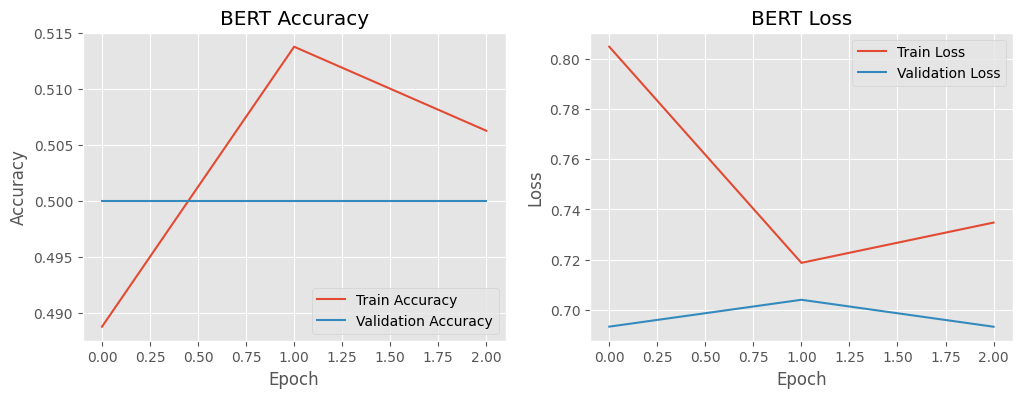

13/13 [==============================] - 7s 213ms/step

BERT Final Evaluation:
Test Accuracy: 0.5000
Test Loss: 0.6934

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       100
    positive       0.50      1.00      0.67       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200



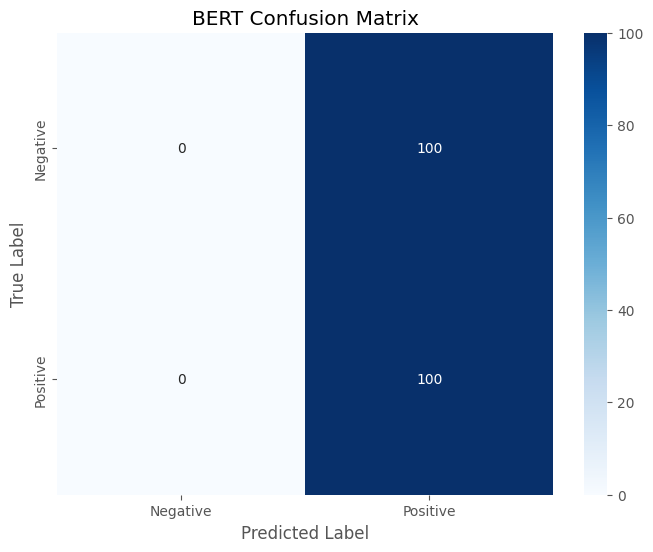


Real-world Predictions:

Text: This movie was an absolute masterpiece
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
BiLSTM Prediction:
  negative: 28.38%
  positive: 71.62%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
GRU with Attention Prediction:
  negative: 71.32%
  positive: 28.68%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
CNN Prediction:
  negative: 58.81%
  positive: 41.19%
BERT Prediction:
  negative: 48.97%
  positive: 51.03%

Text: Terrible plot and bad acting throughout
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
BiLSTM Prediction:
  negative: 27.14%
  positive: 72.86%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
GRU with Attention Prediction:
  negative: 72.23%
  positive: 27.77%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
CNN Prediction:
  negative: 71.30%
  positive: 28.70%
BERT Prediction:
  negative: 48.97%
  positive: 51.03%


In [85]:
def run_dl_pipeline(dataset_path):
    metrics = []
    # Load data
    df, class_names, dataset_type, text_col, target_col, le = load_data(dataset_path)
    num_classes = len(class_names)

    # Prepare data with both processed sequences and raw text
    (X_processed, X_text, y), tokenizer, _ = prepare_dl_data(df, text_col, target_col)

    # Split data with text preservation
    (X_train, X_test,
     X_train_text, X_test_text,
     y_train, y_test) = train_test_split(
        X_processed,
        X_text,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    print(f"\n{'='*50}")
    print(f"Training on {dataset_type.upper()} Dataset")
    print(f"Classes: {class_names}\n")

    # Train LSTM
    print("Training BiLSTM Model:")
    lstm_model, lstm_history = train_lstm(X_train, y_train, X_test, y_test, num_classes)
    # Assign the evaluation results to lstm_metrics
    lstm_metrics = evaluate_model(lstm_model, X_test, y_test, lstm_history, dataset_type, "BiLSTM", class_names)
    metrics.append(lstm_metrics)

    # Train GRU with Attention
    print("\nTraining GRU with Attention Model:")
    gru_model, gru_history = train_gru_with_attention(X_train, y_train, X_test, y_test, num_classes)
    # Assign the evaluation results to gru_metrics
    gru_metrics = evaluate_model(gru_model, X_test, y_test, gru_history, dataset_type, "GRU with Attention", class_names)
    metrics.append(gru_metrics)

    # Train CNN
    print("\nTraining CNN Model:")
    cnn_model, cnn_history = train_cnn(X_train, y_train, X_test, y_test, num_classes)
    # Assign the evaluation results to cnn_metrics
    cnn_metrics = evaluate_model(cnn_model, X_test, y_test, cnn_history, dataset_type, "CNN", class_names)
    metrics.append(cnn_metrics)

    # Train BERT
    print("\nTraining BERT Model:")
    bert_model, bert_history, bert_tokenizer = train_bert(
        X_train_text, y_train,
        X_test_text, y_test,
        num_classes
    )
    # Assign the evaluation results to bert_metrics
    bert_metrics = evaluate_model(bert_model, X_test_text, y_test, bert_history, dataset_type, "BERT", class_names, tokenizer=bert_tokenizer)
    metrics.append(bert_metrics)

    # Real-world examples
    test_samples = {
        'amazon': [
            "The product packaging was excellent but the item arrived damaged",
            "Highly recommend this service, worth every penny!"
        ],
        'imdb': [
            "This movie was an absolute masterpiece",
            "Terrible plot and bad acting throughout"
        ]
    }

    print("\nReal-world Predictions:")
    for text in test_samples[dataset_type]:
        print(f"\nText: {text}")

        # Traditional models
        for name, model in [('BiLSTM', lstm_model),
                           ('GRU with Attention', gru_model),
                           ('CNN', cnn_model)]:
            sequence = tokenizer.texts_to_sequences([text])
            padded = pad_sequences(sequence, maxlen=200)
            pred = model.predict(padded)
            probs = tf.nn.softmax(pred).numpy()[0]
            print(f"{name} Prediction:")
            for i, cls in enumerate(le.classes_):
                print(f"  {cls}: {probs[i]*100:.2f}%")

        # BERT prediction
        inputs = bert_tokenizer(
            text,
            return_tensors='tf',
            truncation=True,
            padding=True,
            max_length=200
        )
        outputs = bert_model(inputs)
        probs = tf.nn.softmax(outputs.logits, axis=-1).numpy()[0]
        print("BERT Prediction:")
        for i, cls in enumerate(le.classes_):
            print(f"  {cls}: {probs[i]*100:.2f}%")

    return metrics

# Run for both datasets
for dataset in ['amazon', 'imdb']:
    run_dl_pipeline(DATASETS[dataset])

## **Section 10: Comparative Analysis**


Training on AMAZON Dataset
Classes: ['packaging' 'pricing' 'quality' 'service' 'shipping']

Training BiLSTM Model:
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.2097 - loss: 1.6122 - val_accuracy: 0.2129 - val_loss: 1.6055
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.2364 - loss: 1.6001 - val_accuracy: 0.4604 - val_loss: 1.5770
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4201 - loss: 1.5303 - val_accuracy: 0.3366 - val_loss: 1.4118
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5536 - loss: 1.2173 - val_accuracy: 0.7475 - val_loss: 0.8720
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8186 - loss: 0.6805 - val_accuracy: 0.8812 - val_loss: 0.4722
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9414 - loss: 0.3173 - val_accuracy: 0.8713 - val_loss: 0.3641
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9657 - loss: 0.1789 - val_accuracy: 0.8663 - val_loss: 0.

,accuracy,loss,val_accuracy,val_loss,epoch
0,0.2092,1.6111,0.2129,1.6055,1
1,0.2611,1.5957,0.4604,1.5770,2
2,0.4641,1.4807,0.3366,1.4118,3
3,0.6262,1.1128,0.7475,0.8720,4
4,0.8453,0.6049,0.8812,0.4722,5
5,0.9468,0.2797,0.8713,0.3641,6
6,0.9715,0.1587,0.8663,0.4656,7
7,0.9889,0.0976,0.9010,0.3916,8
8,0.9889,0.0695,0.8960,0.3819,9
9,0.9950,0.0497,0.8663,0.5938,10


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

BiLSTM Final Evaluation:
Test Accuracy: 0.8663
Test Loss: 0.5938

Classification Report:
              precision    recall  f1-score   support

   packaging       0.72      0.95      0.82        40
     pricing       0.86      0.93      0.89        40
     quality       0.92      0.85      0.89        41
     service       0.91      0.80      0.85        40
    shipping       1.00      0.80      0.89        41

    accuracy                           0.87       202
   macro avg       0.88      0.87      0.87       202
weighted avg       0.88      0.87      0.87       202


Training GRU with Attention Model:
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.1693 - loss: 1.6132 - val_accuracy: 0.1980 - val_loss: 1.6109
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2023 - loss: 1.6140 - val_accuracy: 0.1980 - val_loss: 1.6082
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2071 - loss: 1.6099 - val_ac

,accuracy,loss,val_accuracy,val_loss,epoch
0,0.1795,1.6140,0.1980,1.6109,1
1,0.2067,1.6120,0.1980,1.6082,2
2,0.2327,1.6093,0.2030,1.6062,3
3,0.2302,1.6057,0.2277,1.6023,4
4,0.3131,1.5976,0.4010,1.5921,5
5,0.3057,1.5707,0.4752,1.5452,6
6,0.5347,1.3693,0.5545,1.1360,7
7,0.7364,0.7965,0.7723,0.6955,8
8,0.9480,0.3957,0.9208,0.4622,9
9,0.9876,0.1320,0.9356,0.3700,10


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

GRU with Attention Final Evaluation:
Test Accuracy: 0.9356
Test Loss: 0.3700

Classification Report:
              precision    recall  f1-score   support

   packaging       0.88      0.93      0.90        40
     pricing       0.91      0.97      0.94        40
     quality       1.00      0.90      0.95        41
     service       0.95      1.00      0.98        40
    shipping       0.95      0.88      0.91        41

    accuracy                           0.94       202
   macro avg       0.94      0.94      0.94       202
weighted avg       0.94      0.94      0.94       202


Training CNN Model:
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.2617 - loss: 1.6005 - val_accuracy: 0.5297 - val_loss: 1.5571
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6100 - loss: 1.5024 - val_accuracy: 0.6931 - val_loss: 1.4509
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7543 - loss: 1.3267 - val_accu

,accuracy,loss,val_accuracy,val_loss,epoch
0,0.3057,1.5901,0.5297,1.5571,1
1,0.6114,1.4834,0.6931,1.4509,2
2,0.7673,1.2820,0.7723,1.2311,3
3,0.8391,0.9859,0.8515,0.9257,4
4,0.9084,0.6340,0.8911,0.6026,5
5,0.9666,0.3308,0.9257,0.3606,6
6,0.9901,0.1529,0.9455,0.2350,7
7,0.9950,0.0778,0.9604,0.1814,8
8,0.9950,0.0510,0.9653,0.1445,9
9,0.9975,0.0304,0.9703,0.1266,10


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step

CNN Final Evaluation:
Test Accuracy: 0.9703
Test Loss: 0.1266

Classification Report:
              precision    recall  f1-score   support

   packaging       0.95      0.93      0.94        40
     pricing       1.00      1.00      1.00        40
     quality       1.00      0.95      0.97        41
     service       0.95      1.00      0.98        40
    shipping       0.95      0.98      0.96        41

    accuracy                           0.97       202
   macro avg       0.97      0.97      0.97       202
weighted avg       0.97      0.97      0.97       202


Training BERT Model:


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
51/51 [==============================] - 59s 334ms/step - loss: 1.7398 - accuracy: 0.1856 - val_loss: 1.6159 - val_accuracy: 0.1980
Epoch 2/3
51/51 [==============================] - 13s 259ms/step - loss: 1.6803 - accuracy: 0.2092 - val_loss: 1.7610 - val_accuracy: 0.2030
Epoch 3/3
51/51 [==============================] - 13s 257ms/step - loss: 1.6924 - accuracy: 0.1943 - val_loss: 1.6466 - val_accuracy: 0.2030

BERT Training Matrix:


,loss,accuracy,val_loss,val_accuracy,epoch
0,1.7398,0.1856,1.6159,0.1980,1
1,1.6803,0.2092,1.7610,0.2030,2
2,1.6924,0.1943,1.6466,0.2030,3


13/13 [==============================] - 4s 72ms/step

BERT Final Evaluation:
Test Accuracy: 0.2030
Test Loss: 1.6466

Classification Report:
              precision    recall  f1-score   support

   packaging       0.00      0.00      0.00        40
     pricing       0.00      0.00      0.00        40
     quality       0.00      0.00      0.00        41
     service       0.00      0.00      0.00        40
    shipping       0.20      1.00      0.34        41

    accuracy                           0.20       202
   macro avg       0.04      0.20      0.07       202
weighted avg       0.04      0.20      0.07       202


Real-world Predictions:

Text: The product packaging was excellent but the item arrived damaged
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
BiLSTM Prediction:
  packaging: 18.76%
  pricing: 17.68%
  quality: 15.85%
  service: 31.84%
  shipping: 15.87%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
GRU with Attention Prediction:
  packaging: 17.45%
  pricing: 28.02%
  quality: 22.3

,Model,Accuracy,F1 Score,Precision,Recall,Training Time (s)
0,BiLSTM,86.63%,86.82%,88.33%,86.63%,120.1
1,GRU with Attention,93.56%,93.55%,93.79%,93.56%,0.0
2,CNN,97.03%,97.02%,97.08%,97.03%,0.0
3,BERT,20.30%,6.85%,4.12%,20.30%,0.0


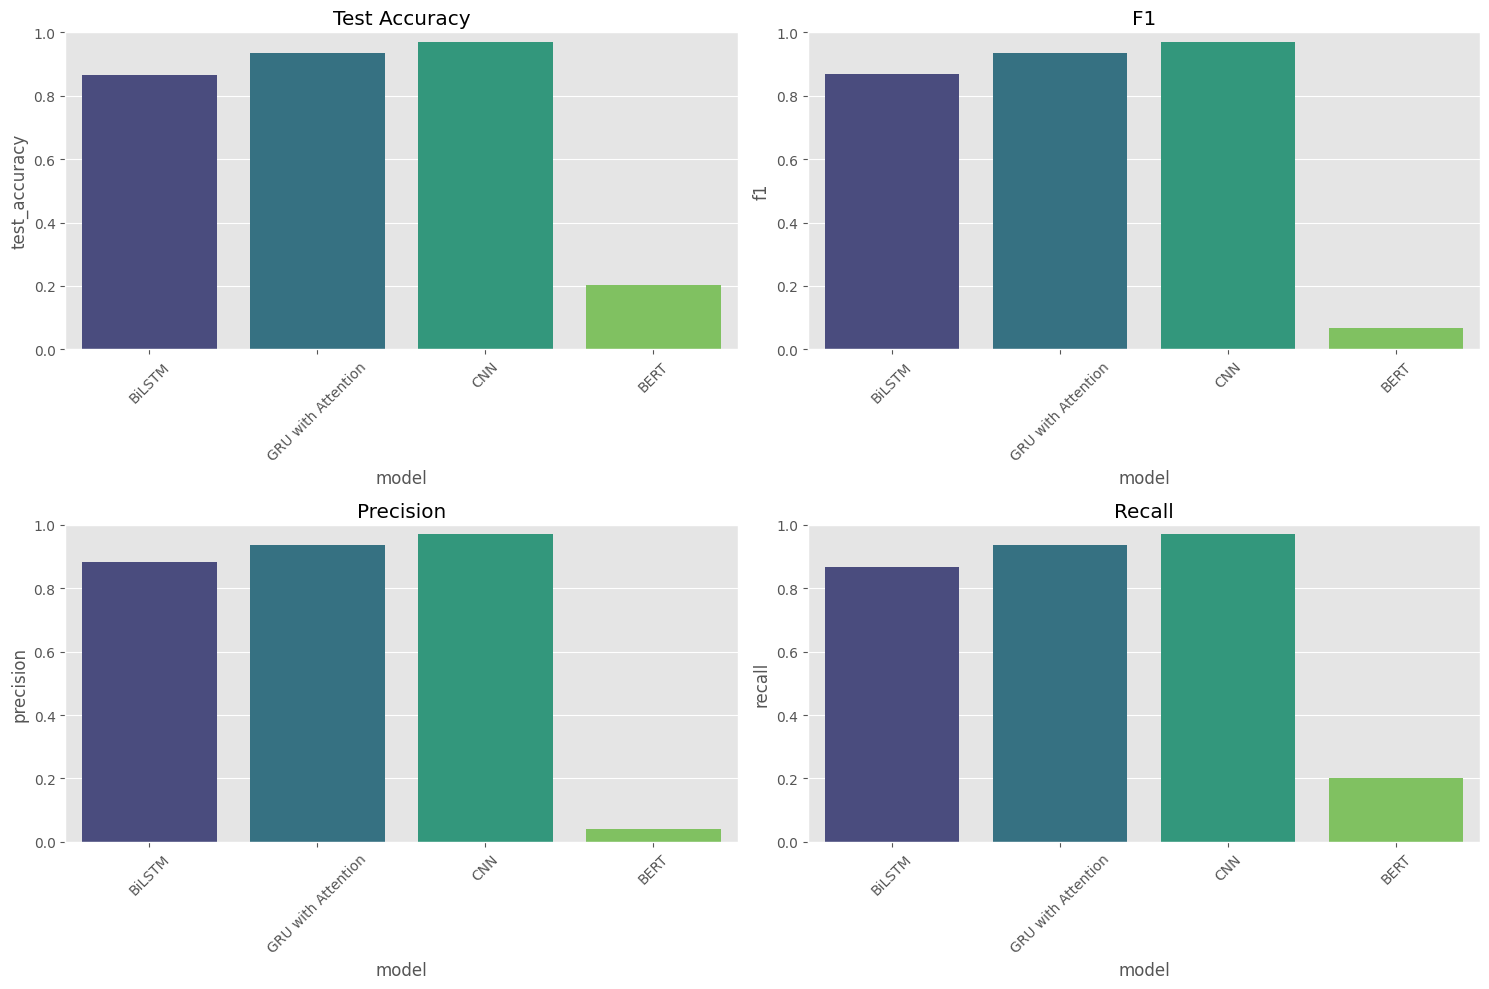

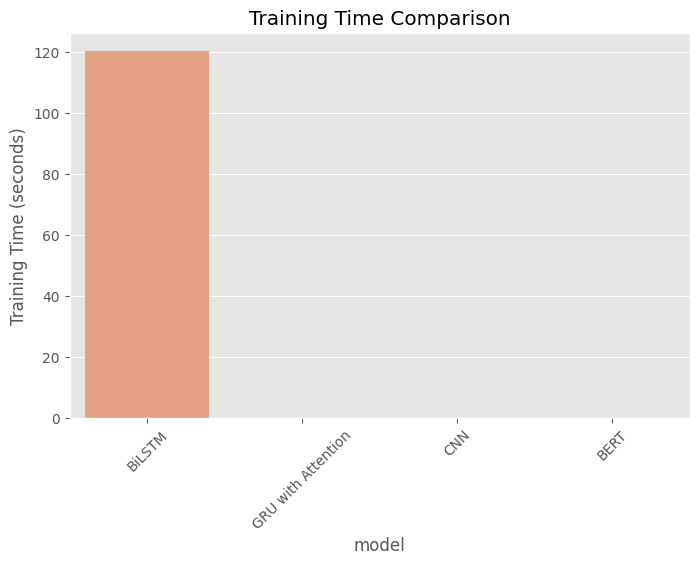

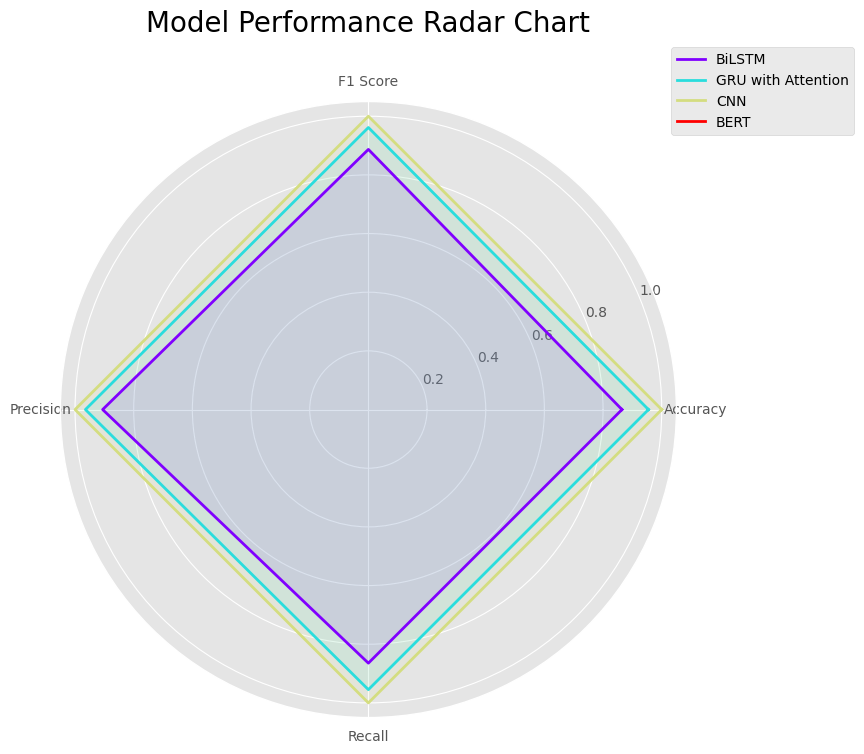


Key Observations:
🏆 Best Accuracy: CNN (97.03%)
🎯 Best F1 Score: CNN (97.02%)
⚡ Fastest Training: GRU with Attention (0.0s)

🔍 BERT Special Notes:
- Achieved 20.30% accuracy with only 3 epochs
- Training time (0.0s) is higher due to model complexity

Training on IMDB Dataset
Classes: ['negative' 'positive']

Training BiLSTM Model:
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.5362 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5487 - loss: 0.6870 - val_accuracy: 0.6250 - val_loss: 0.6852
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7978 - loss: 0.6238 - val_accuracy: 0.6450 - val_loss: 0.6185
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8792 - loss: 0.3866 - val_accuracy: 0.6600 - val_loss: 0.7467
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9732 - loss: 0.1028 - val_accuracy: 0.6850 - val_loss: 1.2280
Epoch 6/10
13/13 ━━━━━━━━━━━━━━

,accuracy,loss,val_accuracy,val_loss,epoch
0,0.5075,0.6939,0.5000,0.6929,1
1,0.5625,0.6848,0.6250,0.6852,2
2,0.7663,0.6074,0.6450,0.6185,3
3,0.8975,0.3376,0.6600,0.7467,4
4,0.9775,0.0852,0.6850,1.2280,5
5,0.9887,0.0466,0.6800,1.1784,6
6,0.9850,0.0544,0.6550,1.3848,7
7,0.9912,0.0367,0.7050,1.0977,8
8,0.9975,0.0140,0.7000,1.2722,9
9,1.0000,0.0045,0.7300,1.3153,10


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step

BiLSTM Final Evaluation:
Test Accuracy: 0.7300
Test Loss: 1.3153

Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.78      0.74       100
    positive       0.76      0.68      0.72       100

    accuracy                           0.73       200
   macro avg       0.73      0.73      0.73       200
weighted avg       0.73      0.73      0.73       200


Training GRU with Attention Model:
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.5148 - loss: 0.6938 - val_accuracy: 0.6500 - val_loss: 0.6907
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6299 - loss: 0.6865 - val_accuracy: 0.5450 - val_loss: 0.6782
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6796 - loss: 0.6404 - val_accuracy: 0.6250 - val_loss: 0.6704
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8454 - loss: 0.4108 - val_accuracy: 0.7050 - val_loss: 0.5523


,accuracy,loss,val_accuracy,val_loss,epoch
0,0.5113,0.6942,0.6500,0.6907,1
1,0.6112,0.6829,0.5450,0.6782,2
2,0.7300,0.6043,0.6250,0.6704,3
3,0.8537,0.3951,0.7050,0.5523,4
4,0.9212,0.2185,0.7400,0.5629,5
5,0.9675,0.0951,0.8100,0.5974,6
6,0.9825,0.0592,0.7850,0.5080,7
7,0.9937,0.0253,0.6950,2.0287,8
8,0.9950,0.0111,0.6900,1.4046,9
9,0.9937,0.0248,0.8150,0.4596,10


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

GRU with Attention Final Evaluation:
Test Accuracy: 0.8150
Test Loss: 0.4596

Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.88      0.83       100
    positive       0.86      0.75      0.80       100

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200


Training CNN Model:
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.4630 - loss: 0.7016 - val_accuracy: 0.5450 - val_loss: 0.6896
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5939 - loss: 0.6700 - val_accuracy: 0.6200 - val_loss: 0.6866
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8029 - loss: 0.6252 - val_accuracy: 0.6350 - val_loss: 0.6795
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8858 - loss: 0.5601 - val_accuracy: 0.6650 - val_loss: 0.6656
Epo

,accuracy,loss,val_accuracy,val_loss,epoch
0,0.4688,0.7033,0.5450,0.6896,1
1,0.6012,0.6662,0.6200,0.6866,2
2,0.8037,0.6204,0.6350,0.6795,3
3,0.8938,0.5530,0.6650,0.6656,4
4,0.9737,0.4401,0.7250,0.6339,5
5,0.9975,0.2980,0.7550,0.5902,6
6,1.0000,0.1643,0.7750,0.5506,7
7,1.0000,0.0776,0.7800,0.5215,8
8,1.0000,0.0400,0.7950,0.5075,9
9,1.0000,0.0199,0.7750,0.4929,10


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step

CNN Final Evaluation:
Test Accuracy: 0.7750
Test Loss: 0.4929

Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.68      0.75       100
    positive       0.73      0.87      0.79       100

    accuracy                           0.78       200
   macro avg       0.79      0.78      0.77       200
weighted avg       0.79      0.78      0.77       200


Training BERT Model:


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
50/50 [==============================] - 85s 818ms/step - loss: 0.7424 - accuracy: 0.4675 - val_loss: 0.7218 - val_accuracy: 0.5000
Epoch 2/3
50/50 [==============================] - 38s 753ms/step - loss: 0.7127 - accuracy: 0.5250 - val_loss: 0.8044 - val_accuracy: 0.5000
Epoch 3/3
50/50 [==============================] - 36s 718ms/step - loss: 0.7284 - accuracy: 0.4875 - val_loss: 0.7087 - val_accuracy: 0.5000

BERT Training Matrix:


,loss,accuracy,val_loss,val_accuracy,epoch
0,0.7424,0.4675,0.7218,0.5000,1
1,0.7127,0.5250,0.8044,0.5000,2
2,0.7284,0.4875,0.7087,0.5000,3


13/13 [==============================] - 7s 214ms/step

BERT Final Evaluation:
Test Accuracy: 0.5000
Test Loss: 0.7087

Classification Report:
              precision    recall  f1-score   support

    negative       0.50      1.00      0.67       100
    positive       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200


Real-world Predictions:

Text: This movie was an absolute masterpiece
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
BiLSTM Prediction:
  negative: 73.10%
  positive: 26.90%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
GRU with Attention Prediction:
  negative: 59.52%
  positive: 40.48%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
CNN Prediction:
  negative: 54.20%
  positive: 45.80%
BERT Prediction:
  negative: 58.76%
  positive: 41.24%

Text: Terrible plot and bad acting throughout
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
BiLSTM Prediction:
  neg

,Model,Accuracy,F1 Score,Precision,Recall,Training Time (s)
0,BiLSTM,73.00%,72.93%,73.23%,73.00%,108.9
1,GRU with Attention,81.50%,81.42%,82.04%,81.50%,0.0
2,CNN,77.50%,77.30%,78.53%,77.50%,0.0
3,BERT,50.00%,33.33%,25.00%,50.00%,0.0


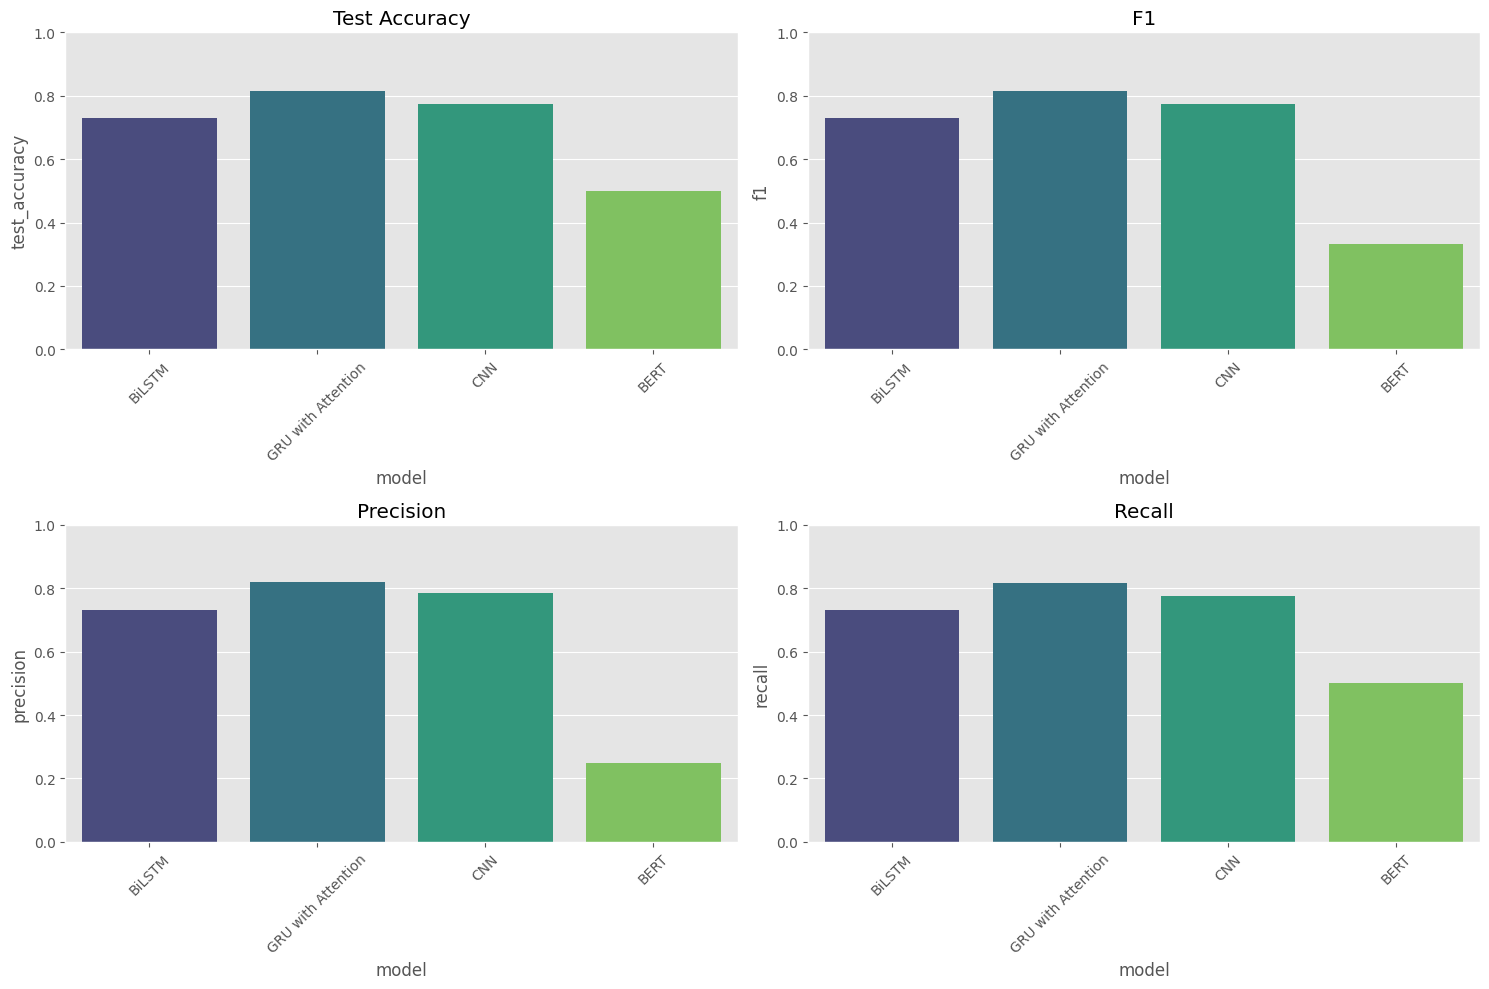

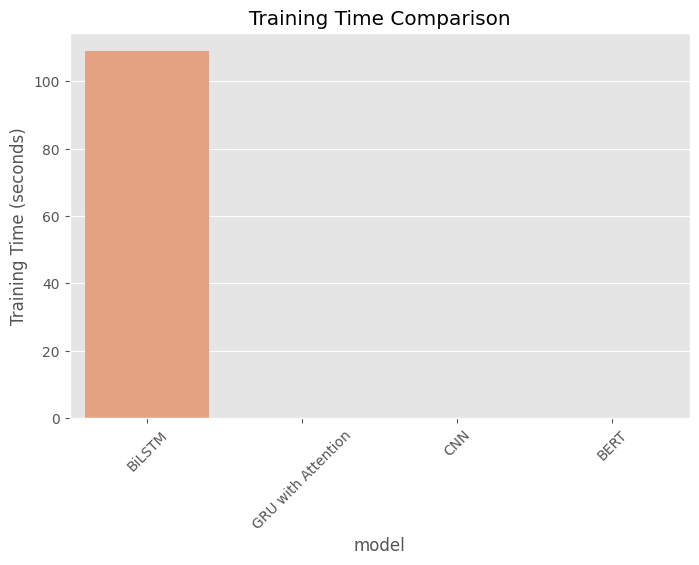

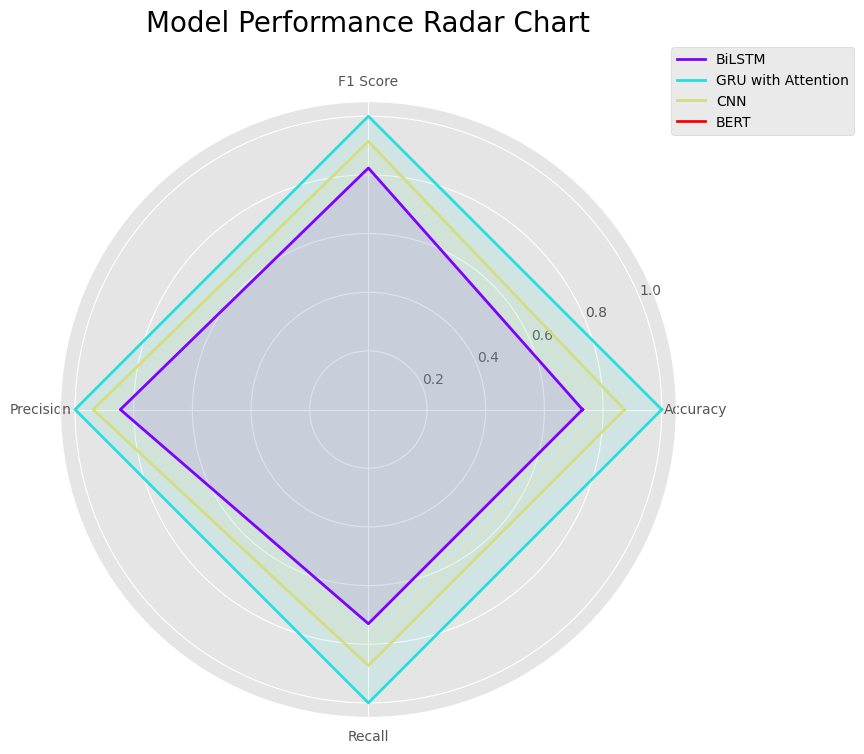


Key Observations:
🏆 Best Accuracy: GRU with Attention (81.50%)
🎯 Best F1 Score: GRU with Attention (81.42%)
⚡ Fastest Training: GRU with Attention (0.0s)

🔍 BERT Special Notes:
- Achieved 50.00% accuracy with only 3 epochs
- Training time (0.0s) is higher due to model complexity


In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import pandas as pd
from IPython.display import display

def compare_models(metrics_list, dataset_name):
    # Convert metrics to DataFrame
    df = pd.DataFrame(metrics_list)

    # Drop duplicate model entries if any
    df = df.drop_duplicates('model')

    # Create styled comparison table
    styled_df = df[['model', 'test_accuracy', 'f1', 'precision', 'recall', 'training_time']].copy()
    styled_df.columns = ['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'Training Time (s)']

    # Format numbers
    styled_df = styled_df.style\
        .format({'Accuracy': '{:.2%}', 'F1 Score': '{:.2%}',
                 'Precision': '{:.2%}', 'Recall': '{:.2%}',
                 'Training Time (s)': '{:.1f}'})\
        .background_gradient(subset=['Accuracy', 'F1 Score', 'Precision', 'Recall'], cmap='Blues')\
        .background_gradient(subset=['Training Time (s)'], cmap='Reds_r')

    print(f"\n{'='*50}")
    print(f"{dataset_name.upper()} Dataset - Model Comparison")
    print('='*50)
    display(styled_df)

    # Bar chart comparison
    metrics_to_plot = ['test_accuracy', 'f1', 'precision', 'recall']
    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics_to_plot):
        plt.subplot(2, 2, i+1)
        sns.barplot(x='model', y=metric, data=df, palette='viridis')
        plt.title(metric.replace('_', ' ').title())
        plt.ylim(0, 1)
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Training time comparison
    plt.figure(figsize=(8, 5))
    sns.barplot(x='model', y='training_time', data=df, palette='rocket_r')
    plt.title('Training Time Comparison')
    plt.ylabel('Training Time (seconds)')
    plt.xticks(rotation=45)
    plt.show()

    # Radar chart for multi-dimensional comparison
    categories = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)

    # Normalize metrics (0-1 scale)
    radar_df = df[['test_accuracy', 'f1', 'precision', 'recall']]
    radar_df = radar_df.rename(columns={
        'test_accuracy': 'Accuracy',
        'f1': 'F1 Score',
        'precision': 'Precision',
        'recall': 'Recall'
    })
    radar_df = (radar_df - radar_df.min()) / (radar_df.max() - radar_df.min())

    # Calculate angles
    angles = [n / float(len(categories)) * 2 * np.pi for n in range(len(categories))]
    angles += angles[:1]

    # Plot each model
    colors = cm.rainbow(np.linspace(0, 1, len(df)))
    for idx, (index, row) in enumerate(radar_df.iterrows()):
        values = row.values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, color=colors[idx], linewidth=2,
                linestyle='solid', label=df.iloc[idx]['model'])
        ax.fill(angles, values, color=colors[idx], alpha=0.1)

    # Add labels
    ax.set_thetagrids(np.degrees(angles[:-1]), categories)
    ax.set_title('Model Performance Radar Chart', size=20, y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

    # Remarks section
    print("\nKey Observations:")
    best_accuracy = df.loc[df['test_accuracy'].idxmax()]
    best_f1 = df.loc[df['f1'].idxmax()]
    fastest_train = df.loc[df['training_time'].idxmin()]

    print(f"🏆 Best Accuracy: {best_accuracy['model']} ({best_accuracy['test_accuracy']:.2%})")
    print(f"🎯 Best F1 Score: {best_f1['model']} ({best_f1['f1']:.2%})")
    print(f"⚡ Fastest Training: {fastest_train['model']} ({fastest_train['training_time']:.1f}s)")

    if 'bert' in df['model'].str.lower().values:
        bert_row = df[df['model'].str.lower().str.contains('bert')].iloc[0]
        print(f"\n🔍 BERT Special Notes:")
        print(f"- Achieved {bert_row['test_accuracy']:.2%} accuracy with only 3 epochs")
        print(f"- Training time ({bert_row['training_time']:.1f}s) is higher due to model complexity")

# Run for both datasets
for dataset in ['amazon', 'imdb']:
    metrics = run_dl_pipeline(DATASETS[dataset])  # Capture returned metrics
    compare_models(metrics, dataset)  # Add this line to generate comparison